In [1]:
# Required Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost
import catboost
import lightgbm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, auc, roc_curve
import pickle
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Load Dataset
data = pd.read_csv("../data/preprocessed_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9730347 entries, 0 to 9730346
Data columns (total 30 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   order_id                        int64  
 2   product_id                      int64  
 3   add_to_cart_order               int64  
 4   reordered                       int64  
 5   user_id                         int64  
 6   order_number                    int64  
 7   days_since_prior_order          float64
 8   average_days_between_purchases  float64
 9   product_purchase_frequency      int64  
 10  total_purchases                 int64  
 11  interval_std_dev                float64
 12  product_reorder_rate            float64
 13  users_general_reorder_rate      float64
 14  avg_add_to_cart_order           float64
 15  order_frequency_by_dow          int64  
 16  aisle_target_enc                float64
 17  department_target_enc      

In [5]:
# Data Preview
data.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,days_since_prior_order,average_days_between_purchases,product_purchase_frequency,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,order_hour_sin,order_hour_cos,add_to_cart_order_encoded,days_since_prior_order_binned
0,0,2722718,8619,9,0,41627,5,15.0,15.000000,1,...,1,0,0,0,0,0,2.588190e-01,-0.965926,8.0,8-15
1,1,2089674,13870,10,0,146296,28,29.0,29.000000,1,...,0,0,0,1,0,0,8.660254e-01,-0.500000,9.0,24-31
2,2,3024155,2029,1,0,6200,2,4.0,4.000000,1,...,0,0,0,0,1,0,7.071068e-01,-0.707107,0.0,0-7
3,3,2890872,16062,2,0,8337,32,2.0,2.000000,1,...,0,0,0,0,1,0,1.224647e-16,-1.000000,1.0,0-7
4,4,1798802,14335,3,0,155167,1,0.0,7.166667,6,...,0,1,0,0,0,0,-9.659258e-01,-0.258819,2.0,Unknown


In [6]:
data = data.drop(columns=("Unnamed: 0"))

In [7]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,days_since_prior_order,average_days_between_purchases,product_purchase_frequency,total_purchases,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,order_hour_sin,order_hour_cos,add_to_cart_order_encoded,days_since_prior_order_binned
0,2722718,8619,9,0,41627,5,15.0,15.000000,1,1,...,1,0,0,0,0,0,2.588190e-01,-0.965926,8.0,8-15
1,2089674,13870,10,0,146296,28,29.0,29.000000,1,1,...,0,0,0,1,0,0,8.660254e-01,-0.500000,9.0,24-31
2,3024155,2029,1,0,6200,2,4.0,4.000000,1,1,...,0,0,0,0,1,0,7.071068e-01,-0.707107,0.0,0-7
3,2890872,16062,2,0,8337,32,2.0,2.000000,1,1,...,0,0,0,0,1,0,1.224647e-16,-1.000000,1.0,0-7
4,1798802,14335,3,0,155167,1,0.0,7.166667,6,6,...,0,1,0,0,0,0,-9.659258e-01,-0.258819,2.0,Unknown


## Model Selection on 30% Data Sample

In [13]:
# Sampling the data using the stratified sampling
def stratified_sample(df, stratify_col, frac):
    stratified_df = df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))
    stratified_df = stratified_df.reset_index(drop=True)
    return stratified_df

sampled_data = stratified_sample(data,'reordered',0.3)

In [15]:
# Train Test Split
sampled_data = sampled_data.drop(columns=(["order_id","product_id","user_id","days_since_prior_order_binned"]))
X = sampled_data.drop(columns="reordered")
y = sampled_data["reordered"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("X_train Shape:",X_train.shape)
print("X_test Shape:",X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:",y_test.shape)

X_train Shape: (2335283, 24)
X_test Shape: (583821, 24)
y_train Shape: (2335283,)
y_test Shape: (583821,)


In [19]:
def Initial_model_selection():
    models = {
        "Logistic Regression with l2 regularization": LogisticRegression(solver='saga',max_iter=1000,penalty='l2',n_jobs=-1),
        "Logistic Regression with l1 regularization": LogisticRegression(solver='saga',max_iter=1000,penalty='l1',n_jobs=-1),
        "Logistic Regression with elastic net regularization": LogisticRegression(solver='saga',max_iter=1000,penalty='elasticnet',n_jobs=-1,l1_ratio=0.5),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Decision Tree": DecisionTreeClassifier(max_depth=1),
        "Naive Bayes": BernoulliNB(),
        "Random Forest": RandomForestClassifier(max_depth=3,n_jobs=-1,n_estimators=50),
        "xgboost": xgboost.XGBClassifier(n_jobs=-1,max_depth=3,n_estimators=50),
        "lightGBM": lightgbm.LGBMClassifier(verbose=-1,n_jobs=-1)
    }
    
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train.fillna(0), y_train, cv=kf, scoring='f1',n_jobs=-1)
        print(name,"cross_validation score:",cv_scores.mean())
        results.append({
            'Model': name,
            'Cross_Val_Scores': cv_scores
        })
    
    
    results_df = pd.DataFrame(results)
    results_df['Mean_Cross_Val'] = results_df['Cross_Val_Scores'].apply(np.mean)
    
    return results_df

In [21]:
cv_data = Initial_model_selection()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with l2 regularization cross_validation score: 0.8151971756195824


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with l1 regularization cross_validation score: 0.815196684664319


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with elastic net regularization cross_validation score: 0.8151957032287853
Linear Discriminant Analysis cross_validation score: 0.8077095344303554


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis cross_validation score: 0.7580698504223161
Decision Tree cross_validation score: 0.8131786914586272
Naive Bayes cross_validation score: 0.8161400824531173
Random Forest cross_validation score: 0.8264635575989692
xgboost cross_validation score: 0.8449928583744659
lightGBM cross_validation score: 0.8480426445395407


In [23]:
cv_data.sort_values(by="Mean_Cross_Val",ascending=False,ignore_index=True)

,Model,Cross_Val_Scores,Mean_Cross_Val
0,lightGBM,"[0.8479973620494504, 0.8492583228137459, 0.847...",0.848043
1,xgboost,"[0.844796378408715, 0.8467845953703207, 0.8445...",0.844993
2,Random Forest,"[0.8297997722908041, 0.8312376970381334, 0.829...",0.826464
3,Naive Bayes,"[0.8161542348505462, 0.8174003667041926, 0.815...",0.816140
4,Logistic Regression with l2 regularization,"[0.8150353307031281, 0.8158951370159337, 0.814...",0.815197
5,Logistic Regression with l1 regularization,"[0.8150316417756284, 0.8158934886623673, 0.815...",0.815197
6,Logistic Regression with elastic net regulariz...,"[0.8150316417756284, 0.8158906308681341, 0.814...",0.815196
7,Decision Tree,"[0.8133375453996572, 0.8146331432844192, 0.812...",0.813179
8,Linear Discriminant Analysis,"[0.808074798436531, 0.8082776944719964, 0.8075...",0.807710
9,Quadratic Discriminant Analysis,"[0.7466837039720597, 0.7582392914719507, 0.800...",0.758070


## Model Selection on Total Data

In [25]:
#Train Test Split
data = data.drop(columns=(["order_id","product_id","user_id","days_since_prior_order_binned"]))
X = data.drop(columns="reordered")
y = data["reordered"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("X_train Shape:",X_train.shape)
print("X_test Shape:",X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:",y_test.shape)

X_train Shape: (7784277, 24)
X_test Shape: (1946070, 24)
y_train Shape: (7784277,)
y_test Shape: (1946070,)


In [27]:
# Final Model Selection
def Final_model_selection():
    models = {
        "Naive Bayes": BernoulliNB(),
        "Random Forest": RandomForestClassifier(max_depth=3,n_jobs=-1,n_estimators=50),
        "xgboost": xgboost.XGBClassifier(n_jobs=-1,max_depth=3,n_estimators=50),
        "lightGBM": lightgbm.LGBMClassifier(verbose=-1,n_jobs=-1)
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train.fillna(0), y_train, cv=kf, scoring='f1',n_jobs=-1)
        print(name,"cross_validation score:",cv_scores.mean())
        results.append({
            'Model': name,
            'Cross_Val_Scores': cv_scores
        })
    
    results_df = pd.DataFrame(results)
    results_df['Mean_Cross_Val'] = results_df['Cross_Val_Scores'].apply(np.mean)
    
    return results_df

In [29]:
final_cv_data = Final_model_selection()

Naive Bayes cross_validation score: 0.815942302727241
Random Forest cross_validation score: 0.828217196725635
xgboost cross_validation score: 0.8449055920237798
lightGBM cross_validation score: 0.8480990645659474


In [31]:
final_cv_data.sort_values(by="Mean_Cross_Val",ascending=False,ignore_index=True)

,Model,Cross_Val_Scores,Mean_Cross_Val
0,lightGBM,"[0.8479706980692057, 0.8485271802468423, 0.848...",0.848099
1,xgboost,"[0.8450553091932909, 0.8453902194263795, 0.845...",0.844906
2,Random Forest,"[0.8291648722581294, 0.8231899905229613, 0.829...",0.828217
3,Naive Bayes,"[0.8157435819995721, 0.8163527739126937, 0.816...",0.815942


## Final Model Evaluation

In [33]:
# Final model fitting
lgb = lightgbm.LGBMClassifier(verbose=-1,n_jobs=-1)
lgb.fit(X_train.fillna(0),y_train)
y_pred = lgb.predict(X_test.fillna(0))


print("accuracy score:",accuracy_score(y_test,y_pred))
print("precision score:",precision_score(y_test,y_pred))
print("Recall score:",recall_score(y_test,y_pred))
print("f1 score:",f1_score(y_test,y_pred))

accuracy score: 0.8244693150811636
precision score: 0.8655902939295267
Recall score: 0.8310742028201695
f1 score: 0.8479811593564383


In [35]:
# Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79    799685
           1       0.87      0.83      0.85   1146385

    accuracy                           0.82   1946070
   macro avg       0.82      0.82      0.82   1946070
weighted avg       0.83      0.82      0.83   1946070



Text(0.5, 1.0, 'Confusion Matrix')

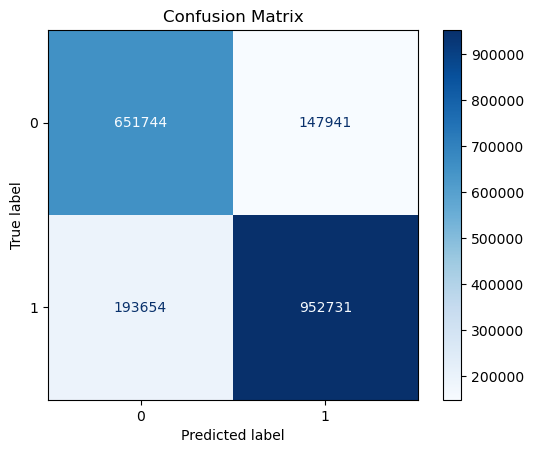

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred,labels=lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")

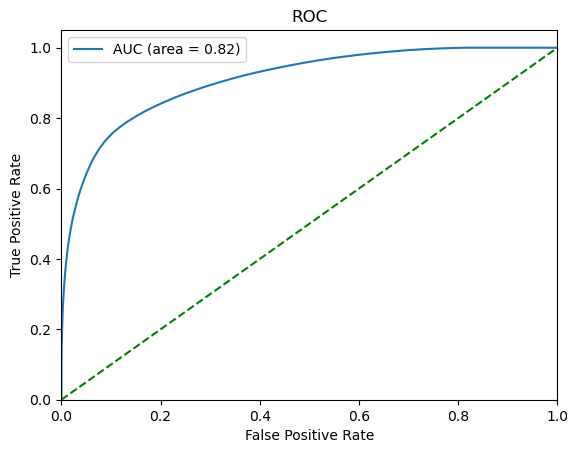

In [37]:
# ROC-AUC Curve
lgb_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, lgb.predict_proba(X_test.fillna(0))[:,1])

plt.figure()
plt.plot(fpr, tpr, label = "AUC (area = %0.2f)" % lgb_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [127]:
# Saving the final model
with open ('../results/best_model.pkl','wb') as file:
    pickle.dump(lgb,file)
print("Model saved")

Model saved
